
Training with Nadam...

Training with SGD...

Training with SGD+m...

Training with AdaGrad...

Training with AdaDelta...

Training with RMSProp...

Training with Adam...

Training with AdaMax...

Nadam:
 - Final Test Loss: 0.3858
 - Final Test Accuracy: 0.8173
 - Convergence Time: 368.84 seconds

SGD:
 - Final Test Loss: 0.3959
 - Final Test Accuracy: 0.8144
 - Convergence Time: 327.09 seconds

SGD+m:
 - Final Test Loss: 0.4015
 - Final Test Accuracy: 0.8102
 - Convergence Time: 335.83 seconds

AdaGrad:
 - Final Test Loss: 0.3783
 - Final Test Accuracy: 0.8171
 - Convergence Time: 387.72 seconds

AdaDelta:
 - Final Test Loss: 0.3951
 - Final Test Accuracy: 0.8134
 - Convergence Time: 357.02 seconds

RMSProp:
 - Final Test Loss: 0.3932
 - Final Test Accuracy: 0.8198
 - Convergence Time: 345.21 seconds

Adam:
 - Final Test Loss: 0.3857
 - Final Test Accuracy: 0.8242
 - Convergence Time: 352.02 seconds

AdaMax:
 - Final Test Loss: 0.5295
 - Final Test Accuracy: 0.7916
 - Convergence Tim

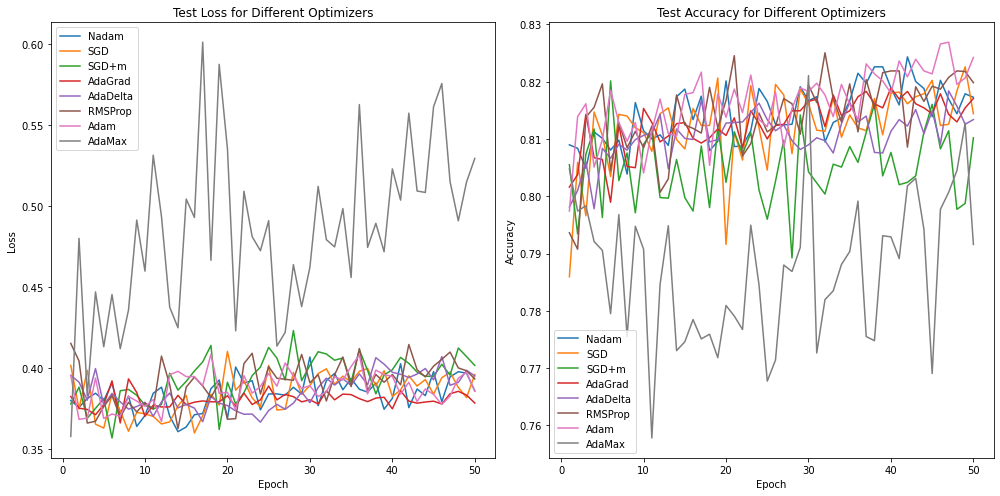

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import time


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Caricamento dei dati
train_df = pd.read_csv('dataset/train_data.csv')
test_df = pd.read_csv('dataset/test_data.csv')

# Preprocessing
X_train = train_df.drop(columns=['income']).values
y_train = train_df['income'].values
X_test = test_df.drop(columns=['income']).values
y_test = test_df['income'].values

# Standardizzazione delle feature
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Applicazione di SMOTE per bilanciare il dataset di addestramento
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Convertiamo le feature e le target in tensori
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Dataset personalizzato
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Creiamo il dataset e dividiamolo in training e validation
full_train_dataset = CustomDataset(X_train, y_train)
train_size = int(0.8 * len(full_train_dataset))  # 80% per il training
val_size = len(full_train_dataset) - train_size  # 20% per la validation
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(CustomDataset(X_test, y_test), batch_size=32, shuffle=False)

# Definizione della rete MLP
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Funzione di training
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    corrects = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = (outputs >= 0.5).float()
        corrects += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = corrects / total
    return epoch_loss, epoch_accuracy

# Funzione di valutazione
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds = (outputs >= 0.5).float()
            corrects += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = corrects / total
    return epoch_loss, epoch_accuracy

# Algoritmi di ottimizzazione da provare
optimizers_info = {
    'Nadam': {'optimizer': lambda params: optim.NAdam(params, lr=0.001, betas=(0.9, 0.999))},
    'SGD': {'optimizer': lambda params: optim.SGD(params, lr=0.1)},
    'SGD+m': {'optimizer': lambda params: optim.SGD(params, lr=0.1, momentum=0.5)},
    'AdaGrad': {'optimizer': lambda params: optim.Adagrad(params, lr=0.1)},
    'AdaDelta': {'optimizer': lambda params: optim.Adadelta(params, lr=0.1, rho=0.95)},
    'RMSProp': {'optimizer': lambda params: optim.RMSprop(params, lr=0.001, alpha=0.99)},
    'Adam': {'optimizer': lambda params: optim.Adam(params, lr=0.001, betas=(0.9, 0.98))},
    'AdaMax': {'optimizer': lambda params: optim.Adamax(params, lr=0.01, betas=(0.85, 0.95))}
    
}

num_epochs = 50
criterion = nn.BCELoss()
results = {}

# Eseguire il ciclo per ogni algoritmo di ottimizzazione
for opt_name, opt_info in optimizers_info.items():
    print(f"\nTraining with {opt_name}...")
    
    # Inizializza il modello e l'ottimizzatore
    model = MLP(input_size=X_train.shape[1]).to(device)
    optimizer = opt_info['optimizer'](model.parameters())
    
    # Per memorizzare le perdite e le accuratezze durante il training
    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []
    
    # Misurare il tempo di inizio per la velocità di convergenza
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Esegui il training e la validazione
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
        
        # Salva i risultati
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    # Calcolare la velocità di convergenza (tempo impiegato per completare il training)
    end_time = time.time()
    convergence_time = end_time - start_time
    
    # Salva i risultati finali
    results[opt_name] = {
        'test_loss': test_losses,
        'test_accuracy': test_accuracies,
        'final_test_loss': test_losses[-1],
        'final_test_accuracy': test_accuracies[-1],
        'convergence_time': convergence_time
    }

# Stampa risultati finali per ogni algoritmo
for opt_name, result in results.items():
    print(f"\n{opt_name}:")
    print(f" - Final Test Loss: {result['final_test_loss']:.4f}")
    print(f" - Final Test Accuracy: {result['final_test_accuracy']:.4f}")
    print(f" - Convergence Time: {result['convergence_time']:.2f} seconds")

# Grafico delle test loss e test accuracy per ogni algoritmo
plt.figure(figsize=(14, 7))

# Plot Test Loss
plt.subplot(1, 2, 1)
for opt_name, result in results.items():
    plt.plot(range(1, num_epochs + 1), result['test_loss'], label=opt_name)
plt.title('Test Loss for Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 2, 2)
for opt_name, result in results.items():
    plt.plot(range(1, num_epochs + 1), result['test_accuracy'], label=opt_name)
plt.title('Test Accuracy for Different Optimizers')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig("optimizer_comparison.png")  # Salva il grafico come PNG
plt.show()
